In [1]:
import tensorflow
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm.notebook
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# create a csv file from data
DATASET_PATH = "data/genres/"

genre = os.listdir(DATASET_PATH)
data = pd.DataFrame(columns = ["filename", "genre", "path","rmse", "chroma_stft", "spec_cent", "spec_bw", "rolloff", "zcr"] + ["mfcc_{}".format(x) for x in range(20)])

filenames = []
genres = []
paths = []

for gnr in genre:
    for file in os.listdir(os.path.join(DATASET_PATH, gnr)):
        filenames.append(file)
        genres.append(gnr)
        paths.append(os.path.join(DATASET_PATH, gnr, file))
data["filename"] = filenames
data["genre"] = genres
data["path"] = paths

data.head()

,filename,genre,path,rmse,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc_0,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
0,blues.00056.au,blues,data/genres/blues/blues.00056.au,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,blues.00063.au,blues,data/genres/blues/blues.00063.au,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,blues.00072.au,blues,data/genres/blues/blues.00072.au,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,blues.00039.au,blues,data/genres/blues/blues.00039.au,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,blues.00030.au,blues,data/genres/blues/blues.00030.au,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Thanks to Parul Pandey (https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8)
# calculate chroma_stft, spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate for every audio sample.

for i,row in tqdm.notebook.tqdm(data.iterrows(), total=1000):
    audio,sr = librosa.load(row.path, duration = 30, mono=True)
    
    row["rmse"] = np.mean(librosa.feature.rms(audio))
    row["chroma_stft"] = np.mean(librosa.feature.chroma_stft(audio, sr=sr))
    row["spec_cent"] = np.mean(librosa.feature.spectral_centroid(audio, sr=sr))
    row["spec_bw"] = np.mean(librosa.feature.spectral_bandwidth(audio, sr=sr))
    row["rolloff"] = np.mean(librosa.feature.spectral_rolloff(audio, sr=sr))
    row["zcr"] = np.mean(librosa.feature.zero_crossing_rate(audio))

 
    for x,i in zip(librosa.feature.mfcc(audio, sr=sr)[:20], range(20)):
        row["mfcc_{}".format(i) ]  = np.mean(x)

In [4]:
data.to_csv("MGC.csv")
data.head()

,filename,genre,path,rmse,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc_0,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
0,blues.00056.au,blues,data/genres/blues/blues.00056.au,0.137728,0.391059,1811.08,2052.33,3927.81,0.0754795,-145.435,...,-6.9346,7.45722,-10.4704,-2.36048,-6.78362,2.67113,-4.76088,-0.949005,0.0248324,-2.00532
1,blues.00063.au,blues,data/genres/blues/blues.00063.au,0.0963262,0.330238,2839.45,2444.14,5711.26,0.154356,-129.086,...,-17.0302,7.10639,-18.0095,2.92272,-14.4768,4.05475,-14.5306,7.25335,-8.2015,-2.00604
2,blues.00072.au,blues,data/genres/blues/blues.00072.au,0.103914,0.306928,2595.54,2519.3,5660.41,0.129246,-118.665,...,-15.7054,3.97841,-27.5423,3.05049,-15.947,10.8686,-12.647,2.82075,-13.3371,-4.37554
3,blues.00039.au,blues,data/genres/blues/blues.00039.au,0.0858679,0.255321,1151.34,1709.19,2312.58,0.0353388,-301.686,...,-17.0113,-10.5729,-15.687,-12.5988,-12.2457,-14.5431,-10.0923,-5.78029,-7.77605,-7.18664
4,blues.00030.au,blues,data/genres/blues/blues.00030.au,0.170081,0.263016,1379.08,2004,3015.83,0.0393758,-206.988,...,-17.7891,-8.01547,-17.6163,-8.13855,-8.64616,-15.539,-15.3315,-9.66487,-10.1033,-17.8351


In [5]:
# scale X
scaler = StandardScaler()
X = scaler.fit_transform( data.drop(["filename","genre","path"],axis=1).values )

# label encode Y
le = LabelEncoder()
Y = le.fit_transform(data.genre.values)

In [6]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.20)

In [7]:
shape = trn_x[0].shape
print(X.shape, shape)

(1000, 26) (26,)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import optimizers

model = Sequential()

model.add(Dense(256,input_shape=shape,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(10,activation='softmax'))

In [9]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [10]:
es = tensorflow.keras.callbacks.EarlyStopping(
    monitor='acc',mode='auto',patience=100,restore_best_weights=True)

history = model.fit(trn_x,trn_y,
                    batch_size=128,
                    epochs=500,
                    validation_data=(val_x,val_y), callbacks=[es])

Epoch 1/500
7/7 [==============================] - 0s 33ms/step - loss: 2.1850 - acc: 0.2200 - val_loss: 1.9390 - val_acc: 0.3100
Epoch 2/500
7/7 [==============================] - 0s 11ms/step - loss: 1.8563 - acc: 0.3363 - val_loss: 1.7418 - val_acc: 0.3350
Epoch 3/500
7/7 [==============================] - 0s 4ms/step - loss: 1.6480 - acc: 0.3762 - val_loss: 1.6245 - val_acc: 0.3700
Epoch 4/500
7/7 [==============================] - 0s 4ms/step - loss: 1.4873 - acc: 0.4613 - val_loss: 1.5165 - val_acc: 0.4350
Epoch 5/500
7/7 [==============================] - 0s 4ms/step - loss: 1.3649 - acc: 0.5450 - val_loss: 1.4450 - val_acc: 0.4950
Epoch 6/500
7/7 [==============================] - 0s 4ms/step - loss: 1.2548 - acc: 0.5500 - val_loss: 1.4093 - val_acc: 0.4750
Epoch 7/500
7/7 [==============================] - 0s 4ms/step - loss: 1.1619 - acc: 0.5863 - val_loss: 1.3456 - val_acc: 0.5550
Epoch 8/500
7/7 [==============================] - 0s 4ms/step - loss: 1.0771 - acc: 0.6413 - v

7/7 [==============================] - 0s 4ms/step - loss: 0.0721 - acc: 0.9887 - val_loss: 1.6047 - val_acc: 0.7100
Epoch 65/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0664 - acc: 0.9937 - val_loss: 1.6244 - val_acc: 0.6750
Epoch 66/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0645 - acc: 0.9912 - val_loss: 1.6444 - val_acc: 0.6800
Epoch 67/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0640 - acc: 0.9937 - val_loss: 1.6296 - val_acc: 0.6950
Epoch 68/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0632 - acc: 0.9925 - val_loss: 1.6738 - val_acc: 0.6800
Epoch 69/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0556 - acc: 0.9962 - val_loss: 1.6626 - val_acc: 0.6850
Epoch 70/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0542 - acc: 0.9937 - val_loss: 1.6524 - val_acc: 0.6700
Epoch 71/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0539 - acc: 0.9975 - val_loss

Epoch 127/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0097 - acc: 0.9975 - val_loss: 2.1283 - val_acc: 0.6750
Epoch 128/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0092 - acc: 0.9987 - val_loss: 2.1163 - val_acc: 0.6750
Epoch 129/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0096 - acc: 0.9975 - val_loss: 2.1309 - val_acc: 0.6750
Epoch 130/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0092 - acc: 0.9987 - val_loss: 2.1462 - val_acc: 0.6800
Epoch 131/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0102 - acc: 0.9962 - val_loss: 2.1566 - val_acc: 0.6750
Epoch 132/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0099 - acc: 0.9987 - val_loss: 2.1575 - val_acc: 0.6750
Epoch 133/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0089 - acc: 0.9987 - val_loss: 2.1494 - val_acc: 0.6700
Epoch 134/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0089 - a

In [13]:
es.best

0.9987499713897705

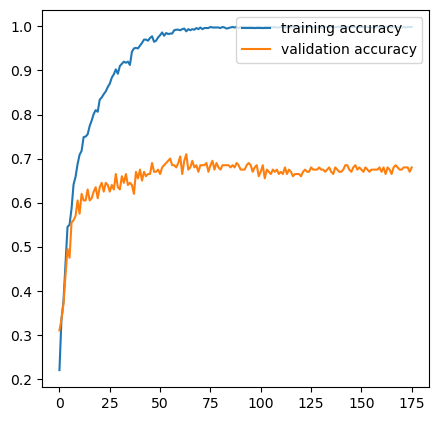

In [21]:
plt.figure(figsize=(5,5),dpi=100)
plt.plot(history.history['acc'],label='training accuracy')
plt.plot(history.history['val_acc'],label='validation accuracy')
plt.legend(loc='upper right')